In [ ]:
# %load boiler_plate.py
# reload modules when they change
%load_ext autoreload
%autoreload 2

# Alow plotting
%matplotlib inline

# Import modules higher in folder hierarchy
import os
import sys


def add_path(path):
    if path not in sys.path:
        sys.path.append(path)


In [ ]:
add_path('..')

In [ ]:
from pipeline.db import fetch, inner_join, filter_videos

# Load data
## Videos data

In [ ]:
dbname='ds-wizards'
user='wizard'
host='192.95.32.117'
password='GaG23jVxZhMnQaU53r8o'

VQUERY = "select post_id, url from videos where status='ok'"

vres = fetch(host, dbname, user, password, VQUERY)
vres = [(post_id.split("_")[1], url) for post_id, url in vres]

## Tags

In [ ]:
dbname='ds-content-tags'
user='ds-content-tags'
password='0fXjWl592vNf1gYvIw8w'
host='192.95.32.117'

TQUERY = "select id, tags from videos where tags is not NULL"
TAGS = "select tag_id, name, path from content_tags"

tres = fetch(host, dbname, user, password, TQUERY)

tags = { 
    tag_id: (name, path) for (tag_id, name, path) in fetch(
        host, dbname, user, password, TAGS) 
}

In [ ]:
import itertools
from collections import Counter

In [ ]:
c = Counter(itertools.chain(*[tags for (_, tags) in tres]))
c_min10 = sorted([(tags[k][0], v  )for k, v in c.items() if v > 10], key = lambda x: x[1], )

In [ ]:
Counter([len(path) for name, path in tags.values()])

In [ ]:
[(name, path) for name, path in tags.values() if len(path) == 2]

## Join videos with tags

In [ ]:
videos = list(inner_join(tres, vres))
filtered, t2i, i2t = filter_videos(videos, 10)
print("Found %d videos with %d unique tags" % (len(filtered), len(t2i)))

In [ ]:
len(filtered), len(t2i)

In [ ]:
len(videos)

In [ ]:
# Take only the most common class from the list
import math

c = Counter([min([t2i.get(t, math.inf) for t in tags]) 
             for (id, tags, url) in videos])

In [ ]:
# Check the new size of the classes
len(c)

# DbPedia

In [ ]:
import requests

from urllib.parse import quote
from xml.etree import ElementTree

In [ ]:
XMLSN = "{http://lookup.dbpedia.org/}"
DBPEDIA_QUERY = "http://lookup.dbpedia.org/api/search/KeywordSearch?&QueryString=%s"
LABEL_PATH = ".//{0}Label".format(XMLSN)
DESCRIPTION_PATH = "{0}Description".format(XMLSN)
RESULT = "{0}Result".format(XMLSN)

In [ ]:
import re

def keep(label):
    if "owl#Thing" in label:
        return False
    
    if "from" in label:
        return False
    
    if "births" in label:
        return False
    
    if "xmlns" in label:
        return False
    
    if re.search(r"american people of [a-z]* descent", label):
        return False
    
    return True

def normalise(label):
    label = label.lower()
    
    return label

In [ ]:
def dbpedia_labels(tag, only_first = True):
    response = requests.get(DBPEDIA_QUERY % quote(tag))
    tree = ElementTree.fromstring(response.content)

    # It there no resutls, return tag and empy list
    if not tree.findall(RESULT):
        raise NameError

    tree = tree[0] if only_first else tree

    # Fetch labels form xml
    labels = [label.text for label in tree.findall(LABEL_PATH)]

    # Clean labels
    labels = [normalise(label) for label in labels if keep(label)]

    # Remove duplicates
    labels = list(set(labels))

    # Get Description
    description = tree.find(DESCRIPTION_PATH).text
    description = description.strip() if description else tag
    
    return description, labels

# Explore DbPedia tags

In [ ]:
for tag_id, (name, path) in itertools.islice(tags.items(), 3):
    try:
        desc, labels =  dbpedia_labels(name)
        print("%s | %s | \n%s" % (tag_id, name, desc))
        for label in labels:
            print("\t %s" % label)
    except NameError:
        print("[Exception] Could not find tags for %s" % name)

In [ ]:
def make_t2l(tags, logging_step=100, only_first = True):
    t2l = {}
    for index, tag_id in enumerate(tags):
        name, path =  tags[tag_id]
        if index % logging_step == 0:
            print("[%d] Fetching info for %s object in dbpedia" % (index, name))
        
        try:
            t2l[tag_id] = dbpedia_labels(name, only_first)
        except NameError:
            print("Could not find label for tag %s" % name)
        except Exception as e:
            print("Exception for %s [%s]" % name, e.message)
        
    return t2l

In [ ]:
t2l = make_t2l(tags)

In [ ]:
labels_raw = itertools.chain(*[set(labels) for (tag_id, (desc, labels)) in t2l.items()])
labels_raw = [normalise(label) for label in labels_raw if keep(label)]
labels = Counter(labels_raw)

In [ ]:
labels_top100 = set([name for name, count in labels.most_common()[:100]])

In [ ]:
t2l_top100 = {}
for tag_id, (desc, labels) in t2l.items():
    labels = [label for label in labels if label in labels_top100]
    if labels:
        t2l_top100[tag_id] = labels

In [ ]:
# Get filterd and raw key
keys_top100 = set(t2l_top100).intersection(set(tags))
keys = set(t2l).intersection(set(tags))

In [ ]:
from collections import namedtuple

In [ ]:
Tag = namedtuple('Tag', ['id', 'name', 'description', 'labels'], verbose=True)

In [ ]:
joined_tags = {k: Tag(k, tags[k][0], t2l[k][0], t2l[k][1])  for k in keys }

In [ ]:
len(keys)

In [ ]:
len(joined_tags)

In [ ]:
for tag_id, tag in itertools.islice(joined_tags.items(), 3):
    print("%s | %s | \n%s" % (tag_id, tag.name, tag.description))
    for label in tag.labels:
        print("\t %s" % label)

# IO

In [ ]:
import pickle

## Save tags

In [ ]:
with open("/data/video/dbpedia_tags.pickle", "wb") as handle:
    pickle.dump(t2l, handle)

## Load tags

In [ ]:
with open("/data/video/dbpedia_tags.pickle", "rb") as handle:
    t2l = pickle.load(handle)

# Clustering

In [ ]:
import spacy
nlp = spacy.load('en')

In [891]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from stop_words import get_stop_words

# load nltk's English stopwords as variable called 'stopwords'
stopwords = set(nltk.corpus.stopwords.words('english')+ get_stop_words('en') +["-PRON-"])

# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer("english")

def filer_tokens(tokens, filter_stopwords=True):
    filtered = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered.append(token)
    
    # remove stop words
    if filter_stopwords:
        filtered = [token for token in filtered if token not in stopwords]
            
    return filtered
    
def tokenize_and_stem(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = filer_tokens(tokens)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = filer_tokens(tokens)
    return filtered_tokens

def tokenize_and_lem(text):
    tokens = [token.lemma_ for token in nlp(text)]
    filtered_tokens = filer_tokens(tokens)
    return filtered_tokens

In [892]:
example = "The Log Cabin Republicans (LCR) is an organization that works within the Republican Party to advocate equal rights for all Americans, including gays and lesbians in the United States. The group's constituency supports the Republican Party and advocates for the rights of gay and lesbian Americans. LCR is the only Republican organization dedicated to representing the interests of LGBT Americans and their allies."

In [893]:
print(example)

The Log Cabin Republicans (LCR) is an organization that works within the Republican Party to advocate equal rights for all Americans, including gays and lesbians in the United States. The group's constituency supports the Republican Party and advocates for the rights of gay and lesbian Americans. LCR is the only Republican organization dedicated to representing the interests of LGBT Americans and their allies.


In [894]:
" ".join(tokenize_only(example))

"log cabin republicans lcr organization works within republican party advocate equal rights americans including gays lesbians united states group 's constituency supports republican party advocates rights gay lesbian americans lcr republican organization dedicated representing interests lgbt americans allies"

In [895]:
" ".join(tokenize_and_stem(example))

"log cabin republican lcr organ work within republican parti advoc equal right american includ gay lesbian unit state group 's constitu support republican parti advoc right gay lesbian american lcr republican organ dedic repres interest lgbt american alli"

In [896]:
" ".join(tokenize_and_lem(example))

"log cabin republicans lcr organization work within republican party advocate equal right americans include gay lesbian united states group 's constituency support republican party advocate right gay lesbian americans lcr republican organization dedicate represent interest lgbt americans ally"

# TF-IDF and document similarity

In [928]:
import numpy as np

In [929]:
# Cluster only on descriptions
descriptions = [tag.description for tag in joined_tags.values()]

# Cluster only on labels
labels = [" ".join(tag.labels) for tag in joined_tags.values()]

# Cluster on both
descriptions_and_labels = ["%s %s" % tup for tup in zip(descriptions, labels)]

# Names
names = [tag.name for tag in joined_tags.values()]

In [930]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01,
                                   max_features=200000, stop_words='english', 
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(descriptions)
print(tfidf_matrix.shape)

CPU times: user 5.85 s, sys: 32 ms, total: 5.88 s
Wall time: 5.89 s
(4517, 539)


In [900]:
terms = tfidf_vectorizer.get_feature_names()

# K-means clustering

In [901]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt

def barplot(clusters):
    x_labels, values = zip(*Counter(clusters).items())

    indexes = np.arange(len(x_labels))
    width = 0.5
    plt.figure(figsize=(20, 5))
    plt.bar(indexes, values, width)
    plt.xticks(indexes, x_labels)
    plt.show()
    
def print_top(km, terms, frame, ntop_words = 15, n_labels = 15):
    print("Top terms per cluster:")
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(km.n_clusters):
        top_words = [terms[i] for i in order_centroids[i, :ntop_words]]
        sample_labels = frame.ix[i]['names'][:n_labels].values

        print("Cluster %d" % i)
        print('WORDS: %s' % ', '.join(top_words))
        print("LABEL NAMES: %s" % ", ".join(sample_labels))
        print() #add whitespace

In [902]:
from sklearn.cluster import KMeans
num_clusters = 25
km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

CPU times: user 11.1 s, sys: 12 ms, total: 11.1 s
Wall time: 11.1 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [903]:
clusters = km.labels_.tolist()

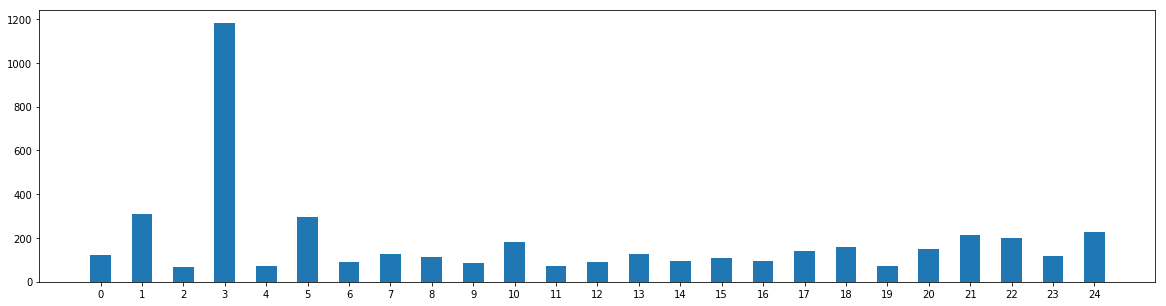

In [904]:
barplot(clusters)

In [905]:
data = { 'names': names, 'descriptions': descriptions_and_labels, 'labels': labels}

frame = pd.DataFrame(data, index = [clusters] , columns = ['names', 'descriptions', 'labels'])

In [906]:
frame.ix[12]

,names,descriptions,labels
12,Google Docs,Google Docs (now known as Google Drive) is a f...,web 2.0 online word processors collaboration o...
12,Lunch,"Extortion (also called blackmail, shakedown, o...",extortion illegal occupations crimes organized...
12,Texting,Short Message Service (SMS) is a text messagin...,short message service text messaging 3rd gener...
12,Internet service provider,An Internet service provider (ISP) is an organ...,internet service providers internet service pr...
12,The Home Depot,The Home Depot is an American retailer of home...,"companies based in atlanta, georgia dow jones ..."
12,Manicure,A manicure is a cosmetic beauty treatment for ...,body modification nail care manicure
12,Sponsor (commercial),"To sponsor something is to support an event, a...",sponsor (commercial) advertising television te...
12,Bus,Public transport (also public transportation o...,transport sustainable transport public transpo...
12,Militia,"The term militia, or irregular army, is common...",paramilitary organizations rebel militia group...
12,Free Wifi,A hotspot is a site that offers Internet acces...,wireless access points wi-fi hotspot (wi-fi)


In [907]:
print_top(km, terms, frame, ntop_words = 20)

Top terms per cluster:
Cluster 0
WORDS: health, sexual, physic, human, care, general, social, relat, refer, term, defin, individu, organ, person, includ, peopl, bodi, cultur, activ, provid
LABEL NAMES: Interracial Romance, Basic income, Major trauma, Physical attractiveness, LGBT social movements, Hiking, Elderly care, Drugstore, Space exploration, Paramedics in the United States, Health (magazine), Clothing, Patient Protection and Affordable Care Act, CARE Package, Human sexuality

Cluster 1
WORDS: state, unit, univers, presid, nation, feder, govern, u.s., american, 's, war, depart, locat, organ, law, research, agenc, right, canada, america
LABEL NAMES: Reading, Federal Communications Commission, Oklahoma, pearl harbor, Minnesota, Arkansas, Baton Rouge, Louisiana, May Day, United States Environmental Protection Agency, Member states of the United Nations, Abortion in the United States, Finance, Cyber Intelligence Sharing and Protection Act, University of Southern California, Environme

# Hierarchical document clustering

In [908]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

In [909]:
n = 100
chart_height = n / 6.25

In [910]:
sampled_ = frame.sample(n=n)

tfidf_matrix_sampled = tfidf_vectorizer.transform(sampled_['descriptions'])
linkage_matrix = ward(1 - cosine_similarity(tfidf_matrix_sampled))

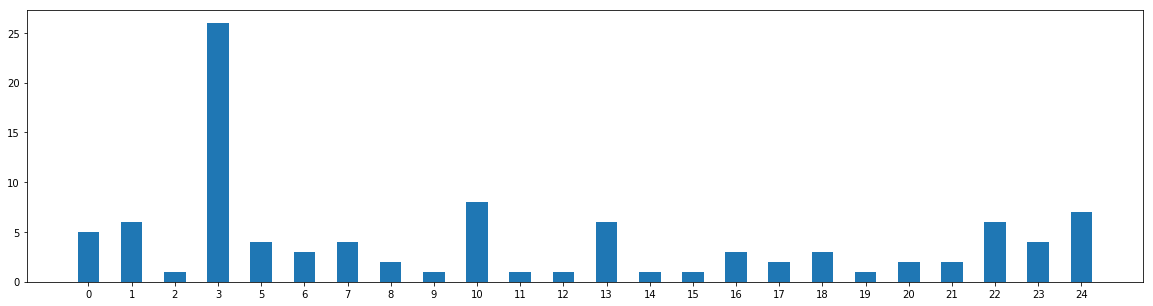

In [911]:
# well, i guess I should use stratified sampling
barplot(sampled_.index)

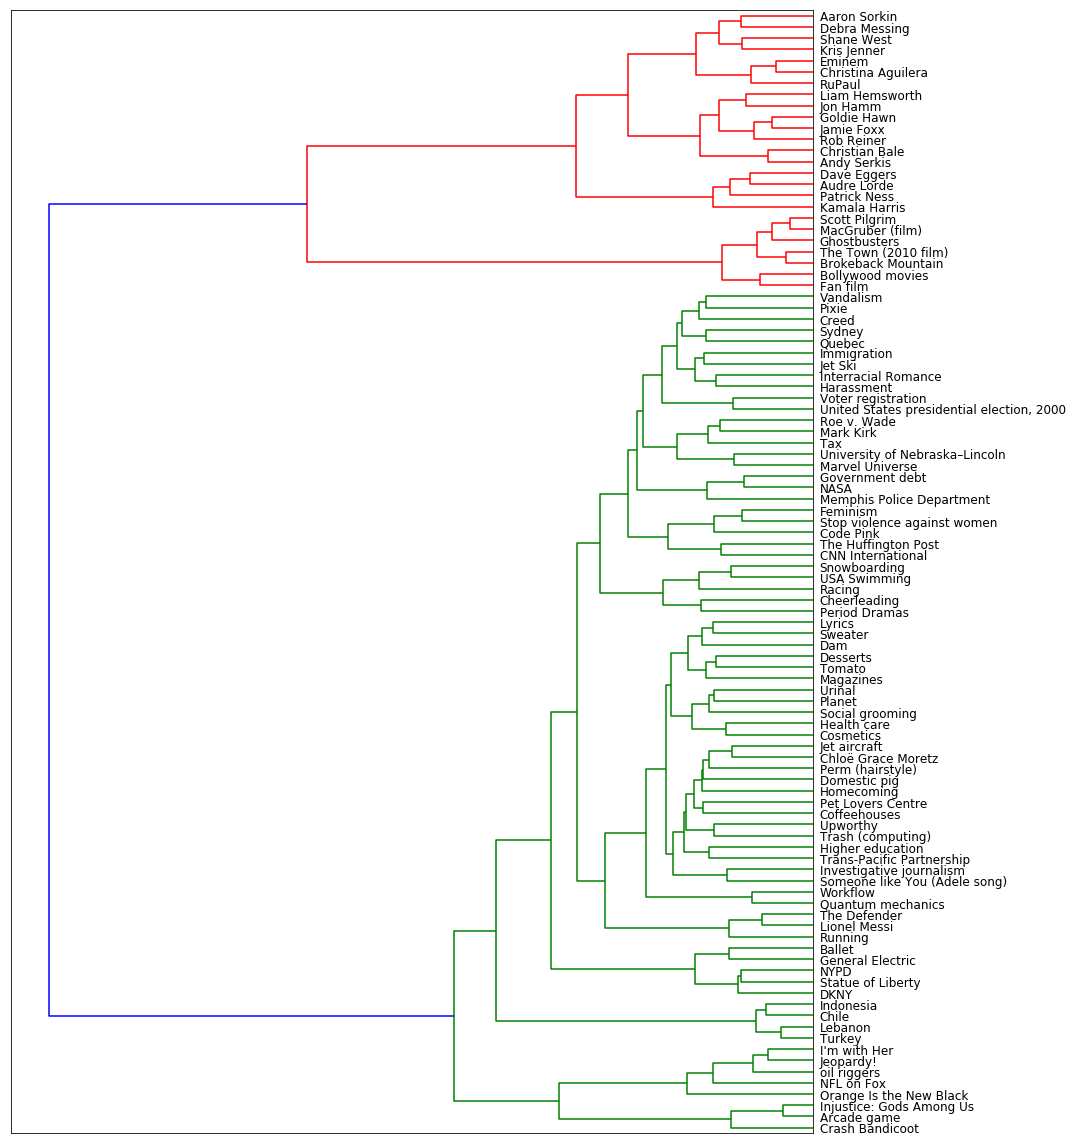

In [912]:
fig, ax = plt.subplots(figsize=(15, chart_height)) # set size
ax = dendrogram(
    linkage_matrix, 
    truncate_mode='mlab',
    orientation="left", 
    labels=sampled_.names.values, 
    leaf_font_size=12.,);
plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

Sampled tags make sense, we could experiment with elbow method to select the optimal number of clusters

# Latent Dirichlet Allocation

In [931]:
from gensim import corpora, models, similarities 

NUM_TOPICS = 20

In [932]:
texts = [tokenize_and_stem(text) for text in descriptions]

In [933]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

## BoW Corpus

In [935]:
lda = models.LdaModel(corpus, num_topics=NUM_TOPICS,
                      id2word=dictionary,
                      update_every=2,
                      chunksize=10000,
                      passes=20)

In [936]:
topics_matrix = lda.show_topics(formatted=False, num_words=10, num_topics=NUM_TOPICS)
topics_matrix = [b for (a, b) in topics_matrix]
topics_matrix = np.array(topics_matrix)

for index, row in enumerate(topics_matrix, 1):
    print("Words for topic %d" % index)
    print(" | ".join(["{0} {1:.3f}".format(word, float(weight)) for (word, weight) in row]))
    print()

Words for topic 1
televis 0.018 | american 0.013 | channel 0.013 | network 0.012 | news 0.010 | born 0.008 | broadcast 0.008 | program 0.008 | unit 0.006 | cabl 0.006

Words for topic 2
citi 0.030 | popul 0.014 | state 0.013 | new 0.012 | area 0.011 | film 0.011 | counti 0.009 | american 0.009 | largest 0.008 | unit 0.008

Words for topic 3
state 0.012 | unit 0.011 | race 0.007 | one 0.007 | forc 0.007 | world 0.006 | popul 0.006 | million 0.005 | citi 0.005 | largest 0.005

Words for topic 4
use 0.018 | game 0.013 | also 0.008 | one 0.007 | sport 0.007 | anim 0.007 | play 0.006 | card 0.006 | ball 0.006 | object 0.005

Words for topic 5
fashion 0.012 | design 0.011 | use 0.010 | comput 0.008 | also 0.008 | product 0.007 | school 0.007 | cell 0.005 | term 0.005 | develop 0.005

Words for topic 6
music 0.021 | use 0.013 | record 0.012 | known 0.008 | rock 0.008 | form 0.007 | also 0.007 | may 0.007 | album 0.007 | band 0.006

Words for topic 7
state 0.024 | unit 0.020 | law 0.012 | depa

In [937]:
## Interactive visualisation
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary, mds='mmds')
pyLDAvis.display(vis)

In [998]:
from gensim.matutils import corpus2dense

def transform_document(text, dictionary,  model, f = tokenize_and_stem, n = NUM_TOPICS):
    tokens = tokenize_and_stem(text) 
    doc = dictionary.doc2bow(tokens)
    dense = corpus2dense([model[doc]], n)
    return dense.T

In [ ]:
lda.

## TF-IDF Corpus

In [954]:
#create TF-IDF model
tfidf = models.TfidfModel(corpus)

#create corpus
corpus_tfidf = tfidf[corpus]

In [971]:
lda_tfidf = models.LdaMulticore(corpus_tfidf, num_topics=NUM_TOPICS, id2word=dictionary, passes=20)

In [972]:
## Interactive visualisation
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(lda_tfidf, corpus_tfidf, dictionary, mds='mmds')
pyLDAvis.display(vis)